# Homework4

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg

In [112]:
def Vander(x,K):
    phi=np.zeros((x.shape[0],K))
    for i in range(K):
        phi[:,i]=x**i
    return phi

def f_theta_MLE(X,Y,k):
    Phi=np.vander(X,k)
    A = Phi.T @ Phi
    b = Phi.T @ Y
    try:
        L=scipy.linalg.cholesky(A,lower=True)
        y=scipy.linalg.solve_triangular(L,b,lower=True)
        return scipy.linalg.solve_triangular(L.T,y)
    except:
        return np.linalg.solve(A,b)

def abs_error(theta,Testdata):
    Xtest=Testdata[0]
    Ytest=Testdata[1]
    return (1/len(Ytest))*np.linalg.norm(np.vander(Xtest,len(theta))@theta-Ytest,2)**2

def split_data(X,Y,NTrain):
    index=np.linspace(0,len(Y)-1,len(Y),dtype=int)
    np.random.shuffle(index)
    X,Y =X[index],Y[index]
    Xtrain,Ytrain=X[:NTrain], Y[:NTrain]
    Xtest,Ytest=X[NTrain:],Y[NTrain:]
    return Xtrain,Ytrain ,Xtest,Ytest


def scatterfig(Xdata,Ydata,title,Xlable,Ylable,legend,color="C0"):
    plt.title(title)
    plt.xlabel(Xlable)
    plt.ylabel(Ylable)
    plt.scatter(Xdata,Ydata,s=7,color="springgreen") if legend=="TEST" else plt.scatter(Xdata,Ydata,s=5,color="y")
    plt.grid() 


def plotfig(Xdata,Ydata,title,Xlable,Ylable,legend,color="C0"):
    plt.title(title)
    plt.xlabel(Xlable)
    plt.ylabel(Ylable)
    plt.plot(Xdata,Ydata)

In [113]:
def gen_MLE(X,Y):   
    return lambda theta: 0.5*np.linalg.norm(np.vander(X,len(theta))@theta-Y,2)**2


def gen_MAP(X,Y,lamda):
    return lambda theta: 0.5*(np.linalg.norm(np.vander(X,len(theta))@theta-Y,2)**2+lamda*np.linalg.norm(theta,2))**2


def grad_MLE(X,Y):
    return lambda theta: np.vander(X,len(theta)).T@np.array(np.vander(X,len(theta))@theta-Y)


def grad_MAP(X,Y,lambda_=0):
    return lambda theta: np.vander(X,len(theta)).T@np.array(np.vander(X,len(theta))@theta-Y) +lambda_*np.array(theta)


def backtracking(f, grad_f, x):
    """
    This function is a simple implementation of the backtracking algorithm for
    the GD (Gradient Descent) method.
    
    f: function. The function that we want to optimize.
    grad_f: function. The gradient of f(x).
    x: ndarray. The actual iterate x_k.
    """
    alpha = 1
    c = 0.8
    tau = 0.25
    
    while f(x - alpha * grad_f(x)) > f(x) - c * alpha * np.linalg.norm(grad_f(x),2)**2 :
        alpha = tau * alpha
        
        if alpha < 1e-3:
            break
    return alpha


def GD(f,grad_f,x0,tolf=10e-6,tolx=10e-6,kmax=100,a=True,lamda=0):
    x = np.zeros((kmax + 1, x0.shape[0])) # righe = x_k, colonne: componenti degli x_k 
    f_val = np.zeros((kmax + 1,))
    grads = np.zeros((kmax + 1, x0.shape[0]))
    err = np.zeros((kmax + 1,))
    #initialise
    x[0] = x0
    f_val[0] = f(x0)
    grads[0] = grad_f(x0)
    err[0] = np.linalg.norm(grads[0])
    k = 1
    
    while(True):
        # new step
        alpha = backtracking(f, grad_f, x[k-1])
        x[k] = x[k-1] - alpha*grads[k-1]
        f_val[k] = f(x[k])
        grads[k] = grad_f(x[k])
        err[k] = np.linalg.norm(grads[k])
        
        
        # check stopping condition
        if k==kmax:
           
            break
        elif np.linalg.norm(grads[k]) <= tolf * np.linalg.norm(grads[k-1]):
            
            break
        elif np.linalg.norm(x[k]- x[k-1]) <= tolx:
              
            break
        k +=1
    
    return x

In [114]:
def SGD(grad_l,w0,data,batch_size,n_epoch,lmda=0):
    alpha=0.01
    X,y=data
    #X=X-np.expand_dims(np.mean(X,axis=1),1)  
    N=int(X.shape[0])
    n_batch_per_epoch=N//batch_size
    d=1
    w=np.array(w0)
    gradl=np.zeros((n_epoch,len(w0)))
    err=np.zeros((n_epoch,))
    w_vec=np.zeros((n_batch_per_epoch*n_epoch,len(w0)))
    
    for epoch in range(n_epoch):
        index=np.linspace(0,len(y)-1,len(y),dtype=int)
        np.random.shuffle(index)
        X=X[index]
        y=y[index]
        for i in range(n_batch_per_epoch):
            Xbetch=X[(i*batch_size):((i+1)*batch_size)]
            ybetch=y[(i*batch_size):((i+1)*batch_size)]
            if lmda==0:
                gradient=grad_l(Xbetch,ybetch)
            else:
                gradient=grad_l(Xbetch,ybetch,lmda)
            w=w-alpha*gradient(w)
            w_vec[epoch * n_batch_per_epoch + i, :]=w
    return w_vec[-1]

In [115]:
def Choose_MLE(modality,Xtrain,Ytrain,k):
    if modality=="S":
        return f_theta_MLE(Xtrain,Ytrain,k)
    elif modality=="GD":
        return GD(gen_MLE(Xtrain,Ytrain),grad_MLE(Xtrain,Ytrain),np.zeros((k,)))[-1]
    else:
        return SGD(grad_MLE,np.zeros((k,)),(Xtrain,Ytrain),8,30)
    

     

### Creazione del Dataset

In [116]:
#Generate the train set
N=100
K=4
theta=np.ones((K,))
a,b=0,1
Xtrain=np.random.uniform(low=a,high=b,size=N)
var=np.sqrt(0.1)
Phi=np.vander(Xtrain,K)
Ytrain=Phi@theta+np.random.normal(0,var,size=N)
#plot the training

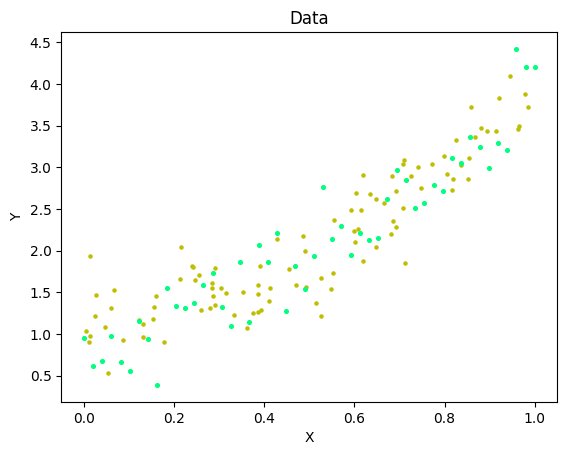

In [117]:
#Generate the test
Ntest=int(N/2)
Xtest=np.linspace(0,1,Ntest)
#Xtest=np.random.uniform(low=a,high=b,size=Ntest)
Phi=np.vander(Xtest,K)
Ytest=Phi@theta+np.random.normal(0,var,size=Ntest)
#plot the training
scatterfig(Xtrain,Ytrain,"Data","X","Y","Train")
scatterfig(Xtest,Ytest,"Data","X","Y","TEST")
plt.show()

###  For different values of K, plot the training datapoints and the test datapoints with different colors, and visualize (as a continuous line) the learnt regression model fθMLE (x). Comment the results.


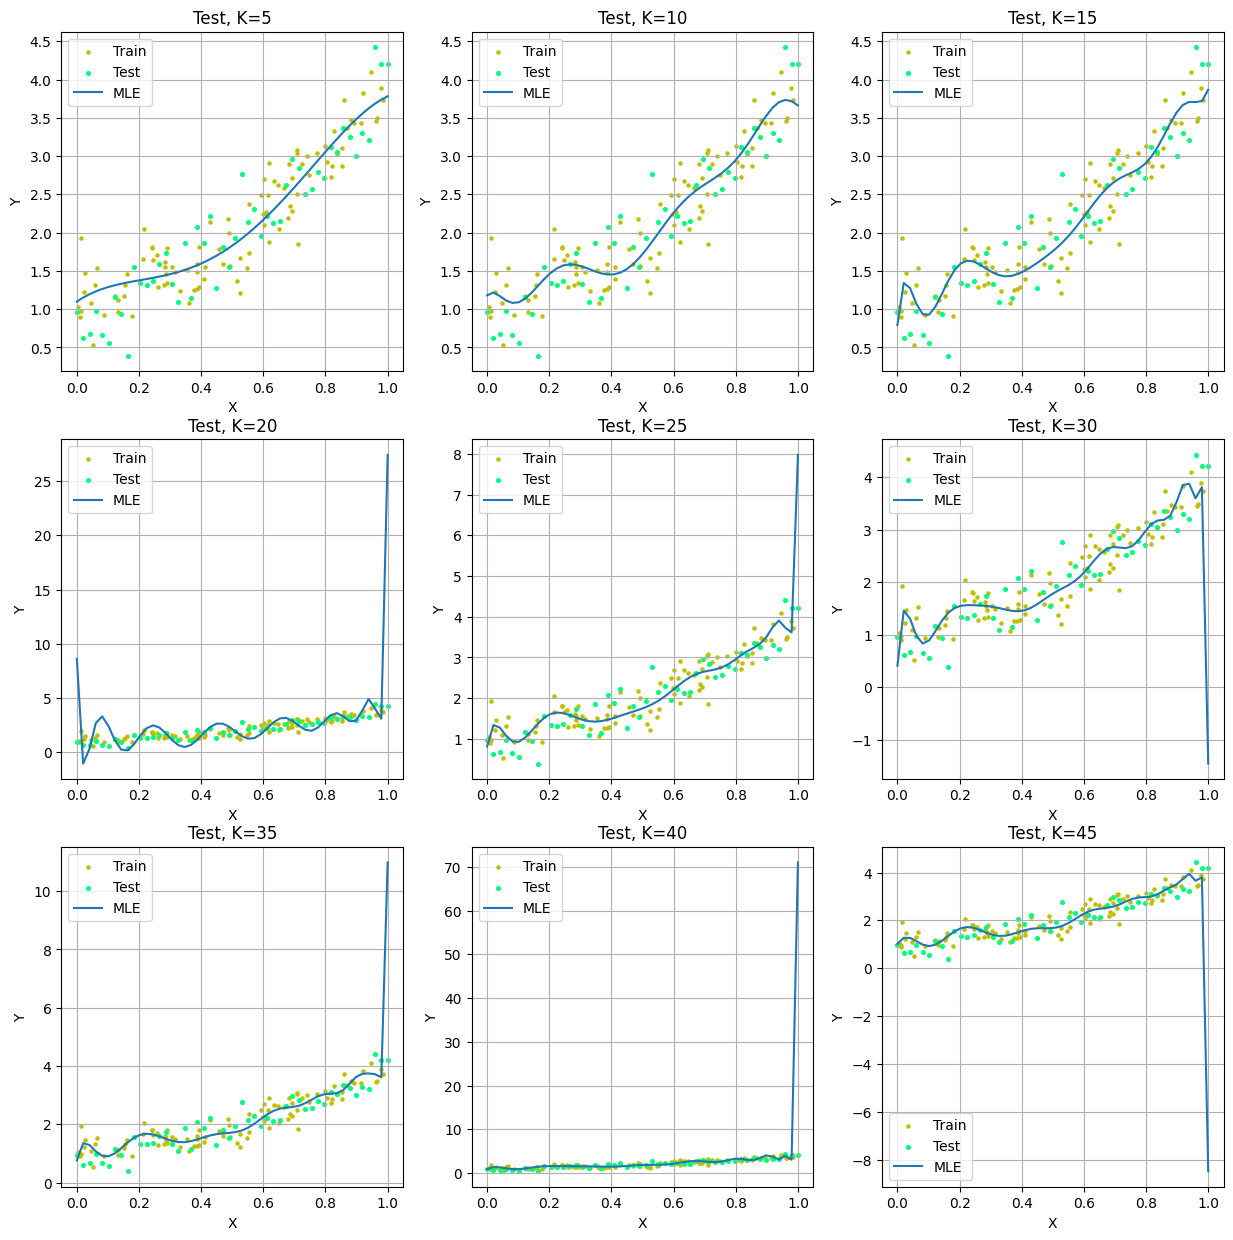

In [118]:

### Poviamo a trovare il k senza sapere quale sia 
K_try=[i for i in range(0,50,5)]
Xtest=np.linspace(0,1,Ntest)
plt.figure(figsize=[15,5*3])
for k in range(1,len(K_try)):
    plt.subplot(3,3,k)
    
    theta_MLE=Choose_MLE("S",Xtrain,Ytrain,K_try[k])
    
    Y_MLE_train=np.vander(Xtrain,K_try[k])@theta_MLE
    Y_MLE_test=np.vander(Xtest,K_try[k])@theta_MLE
    
    
    scatterfig(Xtrain,Ytrain,"Data","X","Y","Train")
    scatterfig(Xtest,Ytest,"Data","X","Y","TEST")
    plotfig(Xtest,Y_MLE_test,f"Test, K={K_try[k]}","X","Y","")
    plt.grid()
    plt.legend(["Train","Test","MLE"])
plt.show()

###  For increasing values of K, use the functions defined above to compute the training and test error, where the test set is generated by sampling Ntest new points on the same interval [a, b] of the training set and generating the corresponding Ytest with the same procedure of the training set. Plot the two errors with respect to K. Comment the results

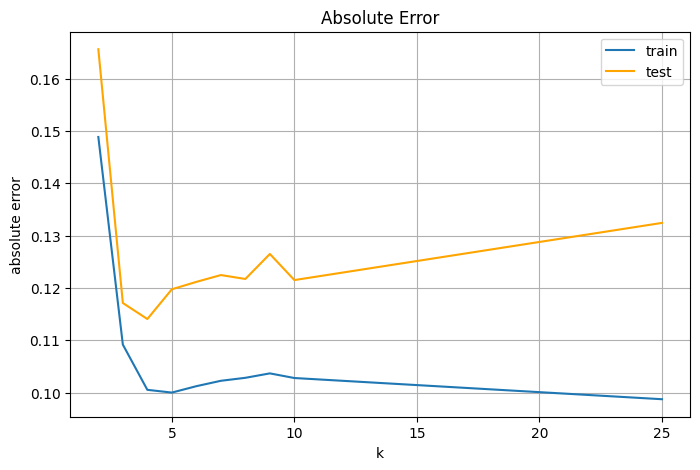

In [119]:
### Poviamo a trovare il k senza sapere quale sia 
K_try=[2,3,4,5,6,7,8,9,10,25]
#Xtest=np.linspace(0,1,Ntest)
plt.figure(figsize=[8,5])
MLEtrain_error=np.zeros((len(K_try)))
MLEtest_error=np.zeros((len(K_try)))
for k in range(len(K_try)):
    
    theta_MLE=Choose_MLE("SGD",Xtrain,Ytrain,K_try[k])
    
    Y_MLE_train=np.vander(Xtrain,K_try[k])@theta_MLE
    Y_MLE_test=np.vander(Xtest,K_try[k])@theta_MLE
    MLEtrain_error[k]=abs_error(theta_MLE,(Xtrain,Ytrain))
    MLEtest_error[k]=abs_error(theta_MLE,(Xtest,Ytest))

plt.plot(K_try,MLEtrain_error,c='C0')
plt.plot(K_try,MLEtest_error,c="orange")
plt.title("Absolute Error")
plt.legend(["train","test"])
plt.xlabel("k")
plt.ylabel("absolute error")
plt.grid()
plt.show()

###  Write a function that takes as input the training data D = (X, Y ), K and λ > 0 and returns the MAP solution (with Gaussian assumption) θMAP ∈ R K for that problem. Note that the loss function can be optimized by GD, SGD or Normal Equations

In [120]:
def ftheta_map(data,k,lamda):
    X,Y=data[0],data[1]
    Phi=np.vander(X,k)
    theta_map_k=np.linalg.solve(Phi.T@Phi + lamda*np.identity(k), Phi.T@Y)
    return theta_map_k

def Choose_MAP(modality,Xtry,Ytry,k,lmda):
    if modality=="False":
        return ftheta_map((Xtry,Ytry),k,lmda)
    elif modality=="GD":
        return GD(gen_MAP(Xtry,Ytry,lmda),grad_MAP(Xtry,Ytry,lmda),np.zeros((k,)))[-1]
    else:
        return SGD(grad_MAP,np.zeros((k,)),(Xtry,Ytry),8,30,lmda)

###  For K lower, equal and greater than the correct degree of the test polynomial, plot the training datapoints and the test datapoints with different colors, and visualize (as a continuous line) the learnt regression model fθMAP (x) with different values of λ. Comment the results.


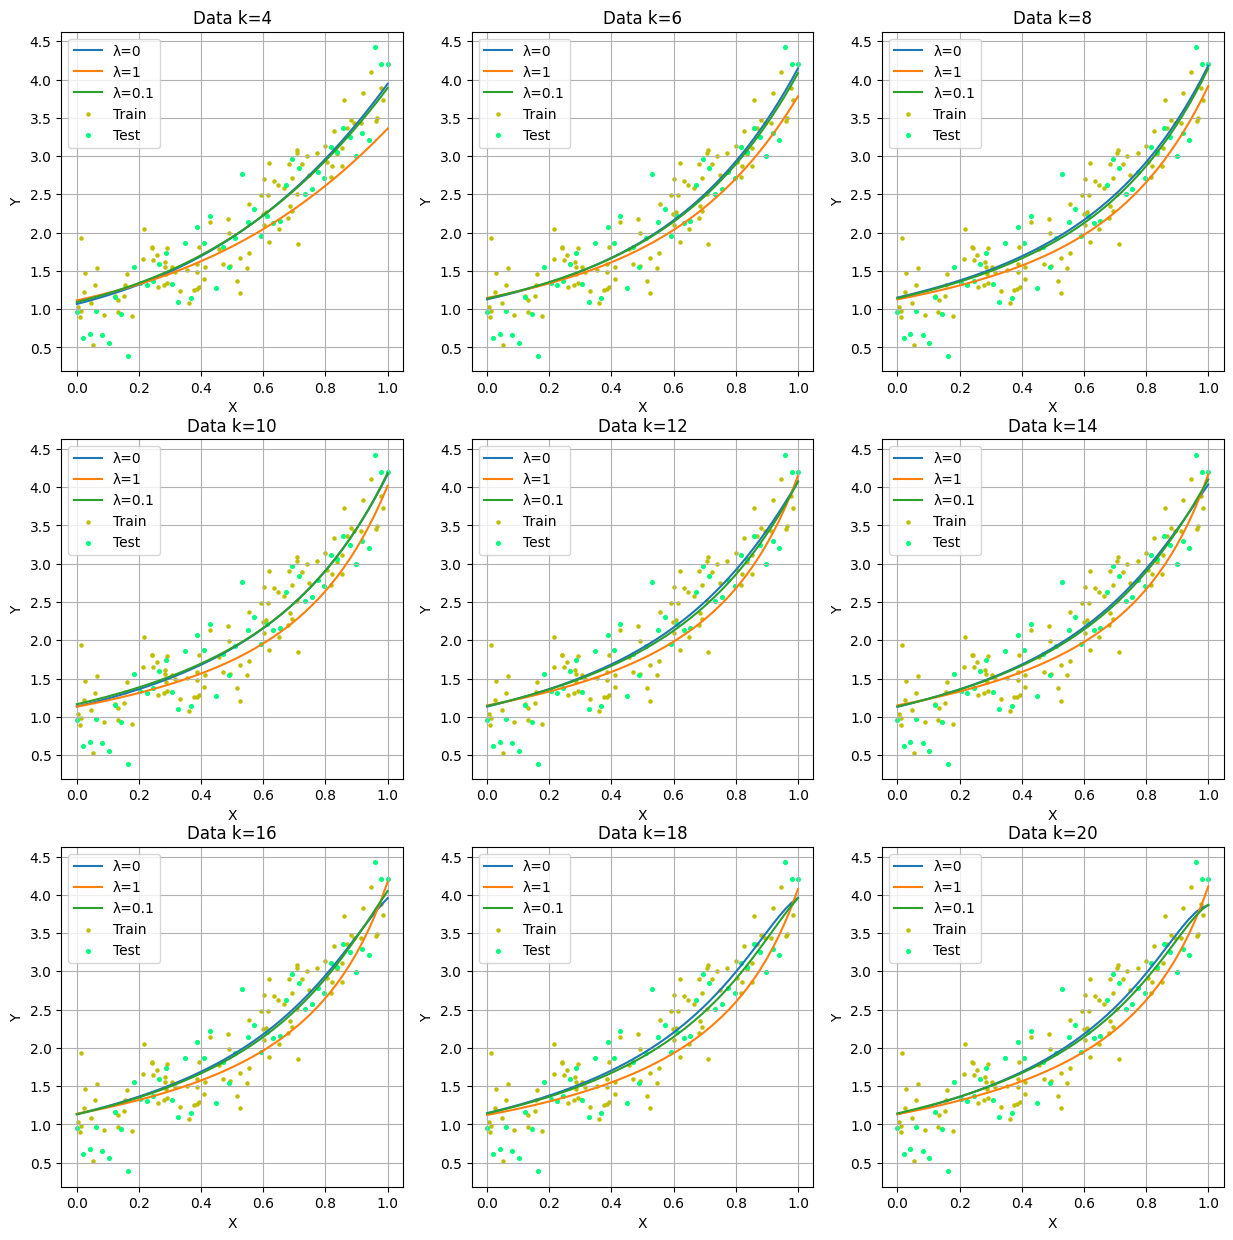

In [121]:
K_try=list(range(2,22,2))
lmda= [0,1,0.1]
plt.figure(figsize=[15,5*3])

for k in range(1,len(K_try)):
    plt.subplot(3,3,k)
    for l in range(len(lmda)):
        for s in ["S","GD","SGD"]:
            theta_MAP=Choose_MAP(s,Xtrain,Ytrain,K_try[k],lmda[l])
            Y_MAP_train=np.vander(Xtrain,K_try[k])@theta_MAP
            Y_MAP_test=np.vander(Xtest,K_try[k])@theta_MAP

        plt.plot(Xtest,Y_MAP_test)
    scatterfig(Xtrain,Ytrain,f"Data K={K_try[k]}","X","Y","Train")
    scatterfig(Xtest,Ytest,f"Data k={K_try[k]}","X","Y","TEST")
    plt.legend([f"λ={i}" for i in lmda]+["Train","Test"])
    plt.grid()
plt.show()      
        

### For K being way greater than the correct degree of the polynomial, compute the MLE and MAP solution. Compare the test error of the two, for different values of λ (in the case of MAP).

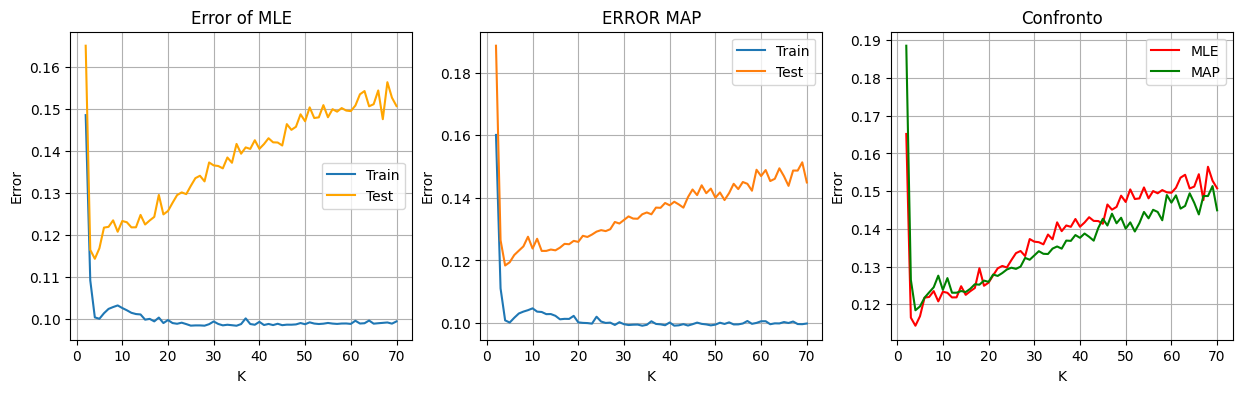

In [131]:
K_try=[i for i in range(2,71,1)]
lmda= [0.1]
MLEtrain_error=np.zeros((len(K_try)))
MLEtest_error=np.zeros((len(K_try)))
MAPtrain_error=np.zeros((len(K_try),len(lmda)))
MAPtest_error=np.zeros((len(K_try),len(lmda)))
for k in range(len(K_try)):
    
    theta_MLE=Choose_MLE("SGD",Xtrain,Ytrain,K_try[k])
    
    MLEtrain_error[k]=abs_error(theta_MLE,(Xtrain,Ytrain))
    MLEtest_error[k]=abs_error(theta_MLE,(Xtest,Ytest))
    
    for l in range(len(lmda)):
        
        theta_MAP=Choose_MAP("SGD",Xtrain,Ytrain,K_try[k],lmda[l])
        
        MAPtrain_error[k,l]=abs_error(theta_MAP,(Xtrain,Ytrain))
        MAPtest_error[k,l]=abs_error(theta_MAP,(Xtest,Ytest))
        
        
# now i plot
plt.figure(figsize=[15,4])
plt.subplot(1,3,1)
plt.title("Error of MLE")
plt.xlabel("K")
plt.ylabel("Error")
plt.plot(K_try,MLEtrain_error,c="C0")
plt.plot(K_try,MLEtest_error,c="orange")
plt.legend(["Train","Test"])
plt.grid()
plt.subplot(1,3,2)
plt.title("ERROR MAP")
plt.xlabel("K")
plt.ylabel("Error")
for l in range(len(lmda)):
    plt.plot(K_try,MAPtrain_error[:,l])
    plt.plot(K_try,MAPtest_error[:,l])
    plt.legend(["Train","Test"])
plt.grid()
plt.subplot(1,3,3)
plt.title("Confronto")
plt.xlabel("K")
plt.ylabel("Error")
plt.plot(K_try,MLEtest_error,c="red")
for l in range(len(lmda)):
    plt.plot(K_try,MAPtest_error[:,l],"green")
plt.legend(['MLE', 'MAP'])
plt.grid()
plt.show()

###  For K greater than the true degree of the polynomial, define Err(θ) = ||θ−θtrue||2 ||θtrue||2 where θtrue has been padded with zeros to match the shape of θ. Compute Err(θMLE) and Err(θMAP ) for increasing values of K and different values of λ.

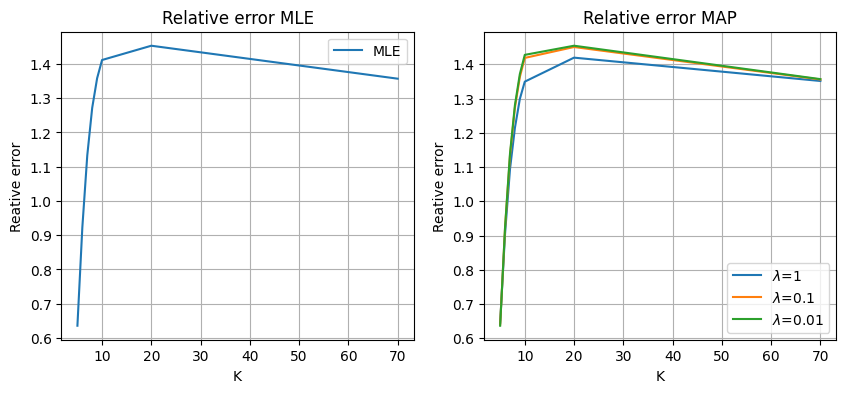

In [128]:
def rel_error(theta):
    return np.linalg.norm(theta-np.concatenate((np.ones((K,)),np.zeros((len(theta)-K,))),axis=0),2)/np.linalg.norm(np.ones((K,)),2)

K_try=[5,6,7,8,9,10,20,70]
lmda= [1,0.1,0.01]

relative_MLE=np.zeros((len(K_try),))
relative_MAP=np.zeros((len(K_try),len(lmda)))
for k in range(len(K_try)):
    
    theta_MLE=Choose_MLE("GD",Xtrain,Ytrain,K_try[k])
    
    relative_MLE[k]=rel_error(theta_MLE)
    for l in range(len(lmda)):
        
        theta_MAP=Choose_MAP("GD",Xtrain,Ytrain,K_try[k],lmda[l])
        
        relative_MAP[k,l]=rel_error(theta_MAP)
        

#now i plot
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.title("Relative error MLE")
plt.xlabel("K")
plt.ylabel("Reative error")
plt.plot(K_try,relative_MLE);
plt.grid()
plt.legend(["MLE"])
plt.subplot(1,2,2)
plt.title("Relative error MAP")
plt.xlabel("K")
plt.ylabel("Reative error")
for l in range(len(lmda)):
        plt.plot(K_try,relative_MAP[:,l])
plt.legend([f"$\lambda$={i}" for i in lmda]);
plt.grid()
plt.show()
